# Word Embedding Experiments
Here we implement all experiments for evaluating the classification performance of different kinds of pretrained word embeddings for complex word identification.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from nltk.corpus import wordnet as wn
from nltk.corpus import sentiwordnet as swn
from nltk.wsd import lesk
import nltk

In [2]:
MAIN_RES = "../cwishareddataset/traindevset/"
df_train = pd.read_csv(MAIN_RES + "english/News_Train.tsv", sep = "\t")
df_test = pd.read_csv(MAIN_RES + "english/News_Dev.tsv", sep = "\t")
columns = ['id', 'sentence', "start", "end", "target", 
              "nat", "non_nat", "nat_marked", "non_nat_marked", "binary", "prob"]
df_train.columns = columns
df_test.columns = columns

In [4]:
from gensim.test.utils import datapath, get_tmpfile
from gensim.models import KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec

MAIN_PATH = 'C:/Users/k_kol/workspace/CoWoReId/python/resources/word-embeddings/'

glove_file = datapath(MAIN_PATH + 'glove.6B.50d.txt')
tmp_file = get_tmpfile("glove2word2vec.txt")

glove2word2vec(glove_file, tmp_file)

model_glove_wiki_50d = KeyedVectors.load_word2vec_format(tmp_file)
model_word2vec_300d = KeyedVectors.load_word2vec_format(datapath(MAIN_PATH + 'GoogleNews-vectors-negative300.bin'), binary=True)

C:\Users\k_kol\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


## (1) Load GloVe embeddings

In [3]:
from gensim.test.utils import datapath, get_tmpfile
from gensim.models import KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec

MAIN_PATH = 'C:/Users/k_kol/workspace/CoWoReId/python/resources/word-embeddings/'

glove_paths = ['glove.6B.50d.txt', 'glove.6B.100d.txt', 'glove.6B.200d.txt', 'glove.6B.300d.txt',
               'glove.42B.300d.txt',  'glove.840B.300d.txt', 'glove.twitter.27B.25d.txt', 
               'glove.twitter.27B.50d.txt', 'glove.twitter.27B.100d.txt', 'glove.twitter.27B.200d.txt']

glove_models = {}
for model_path in glove_paths:
    glove_file = datapath(MAIN_PATH + model_path)
    tmp_file = get_tmpfile(model_path + '-temp')
    glove2word2vec(glove_file, tmp_file)
    glove_models[model_path] = KeyedVectors.load_word2vec_format(tmp_file)
    print('load model : {}'.format(model_path))
    
print(glove_models)

C:\Users\k_kol\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


load model : glove.6B.50d.txt
load model : glove.6B.100d.txt
load model : glove.6B.200d.txt
load model : glove.6B.300d.txt
load model : glove.42B.300d.txt
load model : glove.840B.300d.txt
load model : glove.twitter.27B.25d.txt
load model : glove.twitter.27B.50d.txt
load model : glove.twitter.27B.100d.txt
load model : glove.twitter.27B.200d.txt
{'glove.6B.50d.txt': <gensim.models.keyedvectors.Word2VecKeyedVectors object at 0x00000204A675A080>, 'glove.6B.100d.txt': <gensim.models.keyedvectors.Word2VecKeyedVectors object at 0x00000204B4419EF0>, 'glove.6B.200d.txt': <gensim.models.keyedvectors.Word2VecKeyedVectors object at 0x00000204C665B470>, 'glove.6B.300d.txt': <gensim.models.keyedvectors.Word2VecKeyedVectors object at 0x00000204E2188940>, 'glove.42B.300d.txt': <gensim.models.keyedvectors.Word2VecKeyedVectors object at 0x000002048778D3C8>, 'glove.840B.300d.txt': <gensim.models.keyedvectors.Word2VecKeyedVectors object at 0x00000205AA5B3320>, 'glove.twitter.27B.25d.txt': <gensim.models.k

In [6]:
from ngram_representation import ngram_repr_bag_of_words
from ngram_representation import missing_strat_zeros
from nltk import word_tokenize

def word_embedding(target, model, missing_strat, ngram_repr, *args):
    tokens = word_tokenize(target)
    if len(tokens) > 1:
        # First construct multi-word query
        query = '_'.join(tokens)
        if query in model.vocab:
            return model[query]
        query = '_'.join([token.strip().lower() for token in tokens])
        if query in model.vocab:
            return model[query]
        all_embeddings = [model[word.strip().lower()] 
                              if word.strip().lower() in model.vocab 
                              else missing_strat(word, model.vector_size) 
                              for word in tokens]
        return ngram_repr(all_embeddings, *args)
    else:
        if target in model.vocab:
            return model[target]
        else:
            return model[target.strip().lower()] \
                if target.strip().lower() in model.vocab \
                else missing_strat(target, model.vector_size)

In [7]:
from ngram_representation import ngram_repr_bag_of_words
from ngram_representation import missing_strat_zeros

model = model_glove_wiki_50d
missing_strat = missing_strat_zeros
ngram_repr = ngram_repr_bag_of_words

df_train['word_embedding'] = df_train['target'].apply(lambda target : \
            word_embedding(target, model = model, missing_strat = missing_strat, ngram_repr = ngram_repr_bag_of_words))
df_train['length'] = df_train.target.apply(lambda target : len(target))
df_test['word_embedding'] = df_test['target'].apply(lambda target : \
            word_embedding(target, model = model, missing_strat = missing_strat, ngram_repr = ngram_repr_bag_of_words))
df_test['length'] = df_test.target.apply(lambda target : len(target))

df_train_embeddings = pd.DataFrame(df_train['word_embedding'].values.tolist())
df_test_embeddings = pd.DataFrame(df_test['word_embedding'].values.tolist())
df_f_train = pd.concat([df_train.loc[:,['binary', 'length']], df_train_embeddings], axis = 1)
df_f_test = pd.concat([df_test.loc[:,['binary', 'length']], df_test_embeddings], axis = 1)

In [68]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm

#Prepare training and test data
x_train = df_f_train.loc[:, df_f_train.columns != 'binary']
y_train = df_f_train.binary.values
x_test = df_f_test.loc[:, df_f_test.columns != 'binary']
y_test = df_f_test.binary.values

#Prepare KNN
knn = KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=10, p=2,
           weights='distance')
knn.fit(x_train, y_train) 
prediction_knn = knn.predict(x_test)

svc = svm.SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)
svc.fit(x_train, y_train)   
prediction_svm = svc.predict(x_test)

from sklearn.datasets import load_iris
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier(random_state=0)
iris = load_iris()
cross_val_score(clf, iris.data, iris.target, cv=10)

LR: 0.685225 (0.004390)
LDA: 0.672045 (0.007320)
KNN: 0.786196 (0.008104)
DT: 0.766812 (0.001963)
SVM: 0.796774 (0.002496)


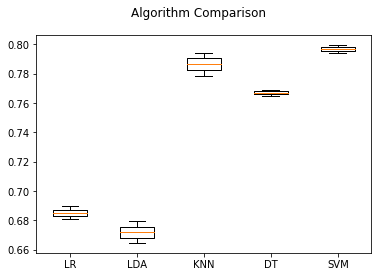

In [13]:
import matplotlib.pyplot as plt
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.metrics import f1_score
from sklearn.metrics import make_scorer

#Prepare training and test data
x_train = df_f_train.loc[:, df_f_train.columns != 'binary']
y_train = df_f_train.binary.values
x_test = df_f_test.loc[:, df_f_test.columns != 'binary']
y_test = df_f_test.binary.values

seed = 7
# Build a collection of classification models to evaluate
classifiers = []
classifiers.append(('LR', LogisticRegression(penalty='l2', dual=False, tol=0.0001, C=1.0, 
                fit_intercept=True, intercept_scaling=1, class_weight=None, random_state=None, 
                solver='liblinear', max_iter=100, multi_class='ovr', verbose=0, warm_start=False,
                n_jobs=1)))
classifiers.append(('LDA', LinearDiscriminantAnalysis()))
classifiers.append(('KNN', KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=10, p=2,
           weights='distance')))
classifiers.append(('DT', DecisionTreeClassifier(criterion='gini', splitter='best', max_depth=None,
           min_samples_split=2, min_samples_leaf=1, min_impurity_split=0 ,min_weight_fraction_leaf=0.0, max_features=None,
           random_state=None, max_leaf_nodes=None, class_weight=None, presort=False)))
classifiers.append(('SVM', SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)))
# evaluate each model in turn
results = []
names = []
for name, model in classifiers:
    kfold = model_selection.KFold(n_splits=2, random_state=seed)
    cv_results = model_selection.cross_val_score(model, x_train, y_train, cv=kfold, scoring=make_scorer(f1_score))
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)
# boxplot results for different classification algorithms
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

In [69]:
from sklearn.metrics import classification_report

print(classification_report(y_test, prediction_knn))
print(classification_report(y_test, prediction_svm))

             precision    recall  f1-score   support

          0       0.83      0.90      0.86      1067
          1       0.83      0.71      0.76       696

avg / total       0.83      0.83      0.82      1763

             precision    recall  f1-score   support

          0       0.84      0.88      0.86      1067
          1       0.80      0.74      0.77       696

avg / total       0.82      0.82      0.82      1763

